# Merging Taxi and Subway Models
---
Now that we have both Taxi and Subway models, and are happy with their performance so far, we will focus on merging the two models/datasets into one model that captures both. Both single models take similar inputs in the form of date time features. The main focus will on finding a way to map/link subway complexes to specific taxi zones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
from shapely.geometry import Point

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

import xgboost as xgb

**The Data:**
We will be loading in and using 4 different datasets to achieve our goal of merging. These are:
- 2022 cleaned taxi data
- 2022 cleaned sibway data
- A zone lookup csv to identify zones
- The Station complex mapping csv created when cleaning the January Subway data

In [2]:
# Load your data
taxi_data = pd.read_csv("2022_taxi_data_cleaned.csv")
subway_data = pd.read_csv("2022_cleaned_subway_data_for_modelling.csv")
zones_lookup = pd.read_csv('NYC_Taxi_Zones/taxi_zone_lookup.csv')
station_complex_mapping = pd.read_csv('station_complex_mapping.csv')

In [3]:
taxi_data

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
0,1,2.0,3.80,1.0,N,142,236,1,14.5,3.0,...,3.65,0.0,0.3,21.95,2.5,0.0,2022-01-01,1,0,Saturday
1,1,1.0,2.10,1.0,N,236,42,1,8.0,0.5,...,4.00,0.0,0.3,13.30,0.0,0.0,2022-01-01,1,0,Saturday
2,2,1.0,0.97,1.0,N,166,166,1,7.5,0.5,...,1.76,0.0,0.3,10.56,0.0,0.0,2022-01-01,1,0,Saturday
3,2,1.0,1.09,1.0,N,114,68,2,8.0,0.5,...,0.00,0.0,0.3,11.80,2.5,0.0,2022-01-01,1,0,Saturday
4,2,1.0,4.30,1.0,N,68,163,1,23.5,0.5,...,3.00,0.0,0.3,30.30,2.5,0.0,2022-01-01,1,0,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31323471,2,1.0,2.62,1.0,N,144,162,2,14.9,1.0,...,0.00,0.0,1.0,19.90,2.5,0.0,2022-12-31,12,23,Saturday
31323472,2,1.0,1.12,1.0,N,161,142,1,8.6,1.0,...,0.00,0.0,1.0,13.60,2.5,0.0,2022-12-31,12,23,Saturday
31323473,2,1.0,1.81,1.0,N,161,141,1,12.8,1.0,...,4.45,0.0,1.0,22.25,2.5,0.0,2022-12-31,12,23,Saturday
31323474,2,1.0,2.35,1.0,N,229,142,2,14.9,1.0,...,0.00,0.0,1.0,19.90,2.5,0.0,2022-12-31,12,23,Saturday


In [4]:
subway_data

,transit_timestamp,station_complex,ridership,Hour,DayOfWeek,DayOfMonth,Month
0,2022-01-01 03:00:00,1 Av (L),0.00,3,5,1,1
1,2022-01-01 04:00:00,1 Av (L),0.00,4,5,1,1
2,2022-01-01 05:00:00,1 Av (L),0.00,5,5,1,1
3,2022-01-01 06:00:00,1 Av (L),0.00,6,5,1,1
4,2022-01-01 07:00:00,1 Av (L),34.75,7,5,1,1
...,...,...,...,...,...,...,...
1039609,2022-12-31 12:00:00,72 St (Q),602.00,12,5,31,12
1039610,2022-12-31 20:00:00,Dyckman St (1),124.00,20,5,31,12
1039611,2022-12-31 01:00:00,"57 St-7 Av (N,Q,R,W)",202.00,1,5,31,12
1039612,2022-12-31 16:00:00,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",4755.00,16,5,31,12


In [5]:
zones_lookup

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [6]:
station_complex_mapping

,station_complex,latitude,longitude,Georeference
0,WTC Cortlandt (1),40.711834,-74.012190,POINT (-74.01219 40.711834)
1,191 St (1),40.855225,-73.929410,POINT (-73.92941 40.855225)
2,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",40.749718,-73.987820,POINT (-73.98782 40.749718)
3,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",40.714110,-74.008580,POINT (-74.00858 40.71411)
4,145 St (3),40.820420,-73.936250,POINT (-73.93625 40.82042)
...,...,...,...,...
115,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",40.725914,-73.994660,POINT (-73.99466 40.725914)
116,Cathedral Pkwy-110 St (1),40.803967,-73.966850,POINT (-73.96685 40.803967)
117,"57 St-7 Av (N,Q,R,W)",40.764664,-73.980660,POINT (-73.98066 40.764664)
118,215 St (1),40.869446,-73.915276,POINT (-73.915276 40.869446)


To make things easier, we will drop any irrelevant columns in the taxi data, and change the date time features to the same Name/Format as the Subway data for smooth merging.

In [7]:
columns_to_drop = ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
                  'PULocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
                  'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge',
                  'airport_fee', 'month', 'day_of_the_week']

In [8]:
taxi_data = taxi_data.drop(columns=columns_to_drop)

In [9]:
taxi_data

,DOLocationID,date,time
0,236,2022-01-01,0
1,42,2022-01-01,0
2,166,2022-01-01,0
3,68,2022-01-01,0
4,163,2022-01-01,0
...,...,...,...
31323471,162,2022-12-31,23
31323472,142,2022-12-31,23
31323473,141,2022-12-31,23
31323474,142,2022-12-31,23


**Extracting the date time features:**

In [10]:
taxi_data['date'] = pd.to_datetime(taxi_data['date'])

taxi_data['DayOfWeek'] = taxi_data['date'].dt.dayofweek
taxi_data['DayOfMonth'] = taxi_data['date'].dt.day
taxi_data['Month'] = taxi_data['date'].dt.month

In [11]:
taxi_data.rename(columns={'time': 'Hour'}, inplace=True)

In [12]:
taxi_data

,DOLocationID,date,Hour,DayOfWeek,DayOfMonth,Month
0,236,2022-01-01,0,5,1,1
1,42,2022-01-01,0,5,1,1
2,166,2022-01-01,0,5,1,1
3,68,2022-01-01,0,5,1,1
4,163,2022-01-01,0,5,1,1
...,...,...,...,...,...,...
31323471,162,2022-12-31,23,5,31,12
31323472,142,2022-12-31,23,5,31,12
31323473,141,2022-12-31,23,5,31,12
31323474,142,2022-12-31,23,5,31,12


**Adding Taxi zones to the Station Mappings:**
The steps to achieve this are as follows:
- Create a new geodataframe called station_complex_geo
- Use the lat and lon coordinates to create a new geometry column in the geodataframe
- Load in the taxi zones shape file to get the outline of each taxi zon
- Perform a spatial join using both, essentially merging based on if the station complex co-ordinates are within a zone.

In [13]:
# Convert the station complex DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(station_complex_mapping.longitude, station_complex_mapping.latitude)]
station_complex_geo = gpd.GeoDataFrame(station_complex_mapping, geometry=geometry)
station_complex_geo.drop('Georeference', axis=1, inplace=True)

In [14]:
station_complex_geo

,station_complex,latitude,longitude,geometry
0,WTC Cortlandt (1),40.711834,-74.012190,POINT (-74.01219 40.71183)
1,191 St (1),40.855225,-73.929410,POINT (-73.92941 40.85522)
2,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",40.749718,-73.987820,POINT (-73.98782 40.74972)
3,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",40.714110,-74.008580,POINT (-74.00858 40.71411)
4,145 St (3),40.820420,-73.936250,POINT (-73.93625 40.82042)
...,...,...,...,...
115,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",40.725914,-73.994660,POINT (-73.99466 40.72591)
116,Cathedral Pkwy-110 St (1),40.803967,-73.966850,POINT (-73.96685 40.80397)
117,"57 St-7 Av (N,Q,R,W)",40.764664,-73.980660,POINT (-73.98066 40.76466)
118,215 St (1),40.869446,-73.915276,POINT (-73.91528 40.86945)


In [15]:
# Taxi zone shapefile
taxi_zones = gpd.read_file('NYC_Taxi_Zones/zones.shp')

In [16]:
taxi_zones

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712..."
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."


In [17]:
# Set the coordinate reference system (CRS) for the station complex GeoDataFrame to match the taxi zones GeoDataFrame
station_complex_geo.set_crs(taxi_zones.crs, inplace=True)

# Perform the spatial join
station_zones = gpd.sjoin(station_complex_geo, taxi_zones, how="left", predicate='within')

In [18]:
station_zones

,station_complex,latitude,longitude,geometry,index_right,borough,location_i,objectid,shape_area,shape_leng,zone
0,WTC Cortlandt (1),40.711834,-74.012190,POINT (-74.01219 40.71183),261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center
1,191 St (1),40.855225,-73.929410,POINT (-73.92941 40.85522),245,Manhattan,243.0,243.0,0.000438,0.094331,Washington Heights North
2,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",40.749718,-73.987820,POINT (-73.98782 40.74972),185,Manhattan,186.0,186.0,0.000037,0.024696,Penn Station/Madison Sq West
3,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",40.714110,-74.008580,POINT (-74.00858 40.71411),230,Manhattan,231.0,231.0,0.000167,0.063420,TriBeCa/Civic Center
4,145 St (3),40.820420,-73.936250,POINT (-73.93625 40.82042),43,Manhattan,42.0,42.0,0.000264,0.092709,Central Harlem North
...,...,...,...,...,...,...,...,...,...,...,...
115,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",40.725914,-73.994660,POINT (-73.99466 40.72591),114,Manhattan,114.0,114.0,0.000047,0.031727,Greenwich Village South
116,Cathedral Pkwy-110 St (1),40.803967,-73.966850,POINT (-73.96685 40.80397),9,Manhattan,24.0,24.0,0.000061,0.047000,Bloomingdale
117,"57 St-7 Av (N,Q,R,W)",40.764664,-73.980660,POINT (-73.98066 40.76466),162,Manhattan,163.0,163.0,0.000041,0.034177,Midtown North
118,215 St (1),40.869446,-73.915276,POINT (-73.91528 40.86945),128,Manhattan,127.0,127.0,0.000163,0.060019,Inwood


We now have a full mapping table for each station complex, which can be used to easily map and group station complexes to their respective zones.

## Merging the Taxi and Subway Data 
---
Now that we have a mapping table completed, we can move on and use this new table to actually merge the taxi and subway data into one. 
<br><br>
This first merge will be **merging the corresponding Taxi Zone ID into the 2022 subway data**, so it can easily be linked to the correct rows in the taxi data.

In [19]:
merged_data = pd.merge(station_zones[['station_complex', 'location_i']], subway_data, on='station_complex')

In [20]:
merged_data.rename(columns={'location_i': 'DOLocationID'}, inplace=True)

In [21]:
merged_data

,station_complex,DOLocationID,transit_timestamp,ridership,Hour,DayOfWeek,DayOfMonth,Month
0,WTC Cortlandt (1),261.0,2022-01-01 00:00:00,0.00,0,5,1,1
1,WTC Cortlandt (1),261.0,2022-01-01 01:00:00,0.00,1,5,1,1
2,WTC Cortlandt (1),261.0,2022-01-01 02:00:00,0.00,2,5,1,1
3,WTC Cortlandt (1),261.0,2022-01-01 03:00:00,0.00,3,5,1,1
4,WTC Cortlandt (1),261.0,2022-01-01 04:00:00,43.75,4,5,1,1
...,...,...,...,...,...,...,...,...
1039609,"168 St (A,C,1)",244.0,2022-12-31 12:00:00,448.00,12,5,31,12
1039610,"168 St (A,C,1)",244.0,2022-12-31 03:00:00,15.00,3,5,31,12
1039611,"168 St (A,C,1)",244.0,2022-12-31 16:00:00,441.00,16,5,31,12
1039612,"168 St (A,C,1)",244.0,2022-12-31 08:00:00,331.00,8,5,31,12


**Quick test to see if things look right:**
I just want to do a quick check to make sure nothing has gone astray, and ensure all station complexes are still right. I also want to see how many unique zone IDs are present for subway data.

In [22]:
print('Number of unique Station Complexes: ' + str(merged_data['station_complex'].nunique()))

Number of unique Station Complexes: 120


In [23]:
print('Number of unique zone IDs: ' + str(merged_data['DOLocationID'].nunique()))

Number of unique zone IDs: 50


**Observation:** We only have 50 unique zone IDs, compared to 67 zones in Manhattan. We noticed in our first exploration not all taxi zones have a subway complex within them. So this makes sense. We will plot all taxi zones and subway complexes on a map, just to see if 17 seems correct for zones not having a station.

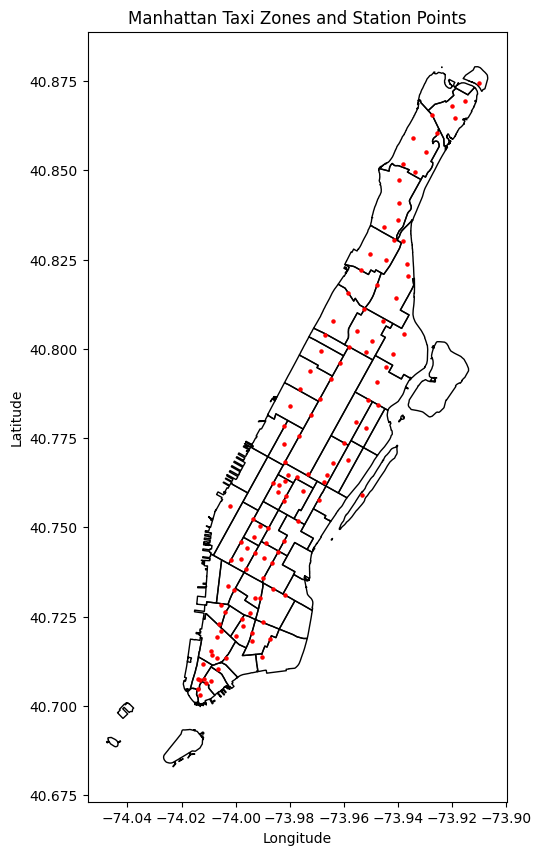

In [24]:
manhattan_taxi_zones = taxi_zones[taxi_zones['borough'] == 'Manhattan']

fig, ax = plt.subplots(figsize=(10, 10))

# Plot Manhattan taxi zones
manhattan_taxi_zones.plot(ax=ax, facecolor='none', edgecolor='black')

# Plot station points
station_complex_geo.plot(ax=ax, color='red', markersize=5)

ax.set_title('Manhattan Taxi Zones and Station Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

17 seems about right, we can see from the plot that indeed many zones don't have a station complex within them.

**Grouping by Zone IDs:**
- Now, we want to group the subway data by Zone ID's before finally merging to the taxi data.
- The reason for this is, we can see from the plot that some Zones have multiple subway complexes.
- Grouping and summing ridership for each Zone at a given Hour/Day/Month can account for this.

In [25]:
grouped_data = merged_data.groupby(['DOLocationID', 'Hour', 'DayOfMonth', 'Month'])['ridership'].sum().reset_index()

In [26]:
grouped_data

,DOLocationID,Hour,DayOfMonth,Month,ridership
0,24.0,0,1,1,0.0
1,24.0,0,1,2,25.0
2,24.0,0,1,3,24.0
3,24.0,0,1,4,37.0
4,24.0,0,1,5,63.0
...,...,...,...,...,...
437331,263.0,23,31,5,122.0
437332,263.0,23,31,7,136.0
437333,263.0,23,31,8,108.0
437334,263.0,23,31,10,118.0


In [27]:
grouped_data.nlargest(10,'ridership')

,DOLocationID,Hour,DayOfMonth,Month,ridership
242422,161.0,17,6,12,27351.0
242457,161.0,17,9,11,26944.0
242518,161.0,17,14,12,26326.0
242599,161.0,17,21,9,26184.0
242504,161.0,17,13,10,26125.0
242361,161.0,17,1,11,26064.0
242492,161.0,17,12,10,25881.0
242434,161.0,17,7,12,25833.0
242529,161.0,17,15,11,25792.0
242506,161.0,17,13,12,25754.0


**The Final Merge: Subway into Taxi data:**
- We can now perform the final merge
- The subway ridership for each zone at a given Hour/Day/Month is added to the 2022 taxi data

In [28]:
df = pd.merge(taxi_data, grouped_data, on=['DOLocationID', 'Hour', 'DayOfMonth', 'Month'], how='left')

In [29]:
df

,DOLocationID,date,Hour,DayOfWeek,DayOfMonth,Month,ridership
0,236,2022-01-01,0,5,1,1,0.0
1,42,2022-01-01,0,5,1,1,0.0
2,166,2022-01-01,0,5,1,1,0.0
3,68,2022-01-01,0,5,1,1,NaN
4,163,2022-01-01,0,5,1,1,0.0
...,...,...,...,...,...,...,...
31323471,162,2022-12-31,23,5,31,12,987.0
31323472,142,2022-12-31,23,5,31,12,1132.0
31323473,141,2022-12-31,23,5,31,12,174.0
31323474,142,2022-12-31,23,5,31,12,1132.0


In [30]:
df.isnull().sum()

DOLocationID          0
date                  0
Hour                  0
DayOfWeek             0
DayOfMonth            0
Month                 0
ridership       5833594
dtype: int64

We have quite a few missing values for ridership. This is likely due to counter resets, and more importantly zones without station complexes in them. To deal with this, we will impute NaN values to 0.

In [31]:
df['ridership'].fillna(0, inplace=True)

In [32]:
df_agg = df.groupby(['DOLocationID', 'Hour', 'DayOfMonth', 'Month']).size().reset_index(name='Dropoffs')

# Join the aggregated DataFrame back to the original DataFrame
df = pd.merge(df, df_agg, how='left', on=['DOLocationID', 'Hour', 'DayOfMonth', 'Month'])

In [33]:
df

,DOLocationID,date,Hour,DayOfWeek,DayOfMonth,Month,ridership,Dropoffs
0,236,2022-01-01,0,5,1,1,0.0,116
1,42,2022-01-01,0,5,1,1,0.0,21
2,166,2022-01-01,0,5,1,1,0.0,32
3,68,2022-01-01,0,5,1,1,0.0,102
4,163,2022-01-01,0,5,1,1,0.0,35
...,...,...,...,...,...,...,...,...
31323471,162,2022-12-31,23,5,31,12,987.0,47
31323472,142,2022-12-31,23,5,31,12,1132.0,85
31323473,141,2022-12-31,23,5,31,12,174.0,86
31323474,142,2022-12-31,23,5,31,12,1132.0,85


In [34]:
df['busyness'] = df['Dropoffs'] + df['ridership']

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DOLocationID,31323476.0,166.331311,68.219543,4.0,114.0,163.0,234.0,263.0
Hour,31323476.0,14.286552,5.605892,0.0,11.0,15.0,19.0,23.0
DayOfWeek,31323476.0,2.966425,1.912323,0.0,1.0,3.0,5.0,6.0
DayOfMonth,31323476.0,15.600160,8.742974,1.0,8.0,15.0,23.0,31.0
Month,31323476.0,6.559385,3.386433,1.0,4.0,6.0,10.0,12.0
ridership,31323476.0,1918.686697,2579.565823,0.0,243.0,1021.0,2481.0,27351.0
Dropoffs,31323476.0,133.979196,91.891007,1.0,67.0,117.0,178.0,559.0
busyness,31323476.0,2052.665893,2623.248716,1.0,314.0,1144.0,2638.0,27552.0


**Observations:**
- There is an inherent imbalance between the number of taxi rides and sibway ridership.
- The mean, max and standard deviation of ridership is much larger than Dropoffs
- This arguably means our busyness is largely based off subway rides instead of taxis
- This might be ok, as it is reflective of what is actually occuring.
- We could also weight both inputs, if deemed necessary or advantageous.
- For now, we will leave it as is but this is something to consider going forward.

In [36]:
df.drop(['ridership', 'Dropoffs'], axis=1, inplace=True)

In [37]:
df

,DOLocationID,date,Hour,DayOfWeek,DayOfMonth,Month,busyness
0,236,2022-01-01,0,5,1,1,116.0
1,42,2022-01-01,0,5,1,1,21.0
2,166,2022-01-01,0,5,1,1,32.0
3,68,2022-01-01,0,5,1,1,102.0
4,163,2022-01-01,0,5,1,1,35.0
...,...,...,...,...,...,...,...
31323471,162,2022-12-31,23,5,31,12,1034.0
31323472,142,2022-12-31,23,5,31,12,1217.0
31323473,141,2022-12-31,23,5,31,12,260.0
31323474,142,2022-12-31,23,5,31,12,1217.0


## Modelling
--- 
The Taxi and Subway Data are now fully merged, and ready for modelling. The steps taken are the same as the individual models. For a detailed analysis please refer to those notebooks or the dev logs on notion.

**Adding Weekend vs Weekday:**

In [38]:
df['Weekend'] = np.where(df['DayOfWeek'].isin([5, 6]), 1, 0)

**Adding Time of Day Blocks:**

In [39]:
bins = [0, 6, 12, 17, 22, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']

# Assign the labels based on the time ranges
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels, right=False, include_lowest=True, ordered=False)

In [40]:
df

,DOLocationID,date,Hour,DayOfWeek,DayOfMonth,Month,busyness,Weekend,TimeOfDay
0,236,2022-01-01,0,5,1,1,116.0,1,Night
1,42,2022-01-01,0,5,1,1,21.0,1,Night
2,166,2022-01-01,0,5,1,1,32.0,1,Night
3,68,2022-01-01,0,5,1,1,102.0,1,Night
4,163,2022-01-01,0,5,1,1,35.0,1,Night
...,...,...,...,...,...,...,...,...,...
31323471,162,2022-12-31,23,5,31,12,1034.0,1,Night
31323472,142,2022-12-31,23,5,31,12,1217.0,1,Night
31323473,141,2022-12-31,23,5,31,12,260.0,1,Night
31323474,142,2022-12-31,23,5,31,12,1217.0,1,Night


**Encoding nominal variables:**

In [41]:
dummies = pd.get_dummies(df['DOLocationID'], prefix='DOLocationID')
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['TimeOfDay'], prefix='TimeOfDay')
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['DayOfWeek'], prefix='DayOfWeek')
df = pd.concat([df, dummies], axis=1)

# Drop the original columns
df = df.drop('DOLocationID', axis=1)
df = df.drop('TimeOfDay', axis=1)
df = df.drop('DayOfWeek', axis=1)

**Train/Test Split:**

In [42]:
# Test data: Returns last 5 days of each month
df_test = df[df['date'].dt.day > df['date'].dt.daysinmonth - 5].copy()

# Train data: Checks for rows not in the new test set
df_train = df[~df.index.isin(df_test.index)].copy()

In [43]:
df_test

,date,Hour,DayOfMonth,Month,busyness,Weekend,DOLocationID_4,DOLocationID_12,DOLocationID_13,DOLocationID_24,...,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
1707973,2022-01-27,0,27,1,1604.00,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1708136,2022-01-27,0,27,1,838.00,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1709939,2022-01-27,0,27,1,430.00,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1709940,2022-01-27,0,27,1,336.00,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1709941,2022-01-27,0,27,1,138.75,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31323471,2022-12-31,23,31,12,1034.00,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
31323472,2022-12-31,23,31,12,1217.00,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
31323473,2022-12-31,23,31,12,260.00,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
31323474,2022-12-31,23,31,12,1217.00,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [44]:
df_train

,date,Hour,DayOfMonth,Month,busyness,Weekend,DOLocationID_4,DOLocationID_12,DOLocationID_13,DOLocationID_24,...,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,2022-01-01,0,1,1,116.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2022-01-01,0,1,1,21.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2022-01-01,0,1,1,32.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,2022-01-01,0,1,1,102.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,2022-01-01,0,1,1,35.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30982311,2022-12-26,23,26,12,223.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
30982425,2022-12-26,23,26,12,370.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
30982441,2022-12-26,23,26,12,3670.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
30982892,2022-12-26,23,26,12,1021.0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [45]:
scaler = MinMaxScaler()

# Scale busyness column for train and test data
df_train['busyness_score'] = scaler.fit_transform(df_train[['busyness']])
df_test['busyness_score'] = scaler.transform(df_test[['busyness']])

In [46]:
df_train.drop(['busyness'], axis=1, inplace=True)
df_test.drop(['busyness'], axis=1, inplace=True)

df_train.drop(['date'], axis=1, inplace=True)
df_test.drop(['date'], axis=1, inplace=True)

In [59]:
df_test

,Hour,DayOfMonth,Month,Weekend,DOLocationID_4,DOLocationID_12,DOLocationID_13,DOLocationID_24,DOLocationID_41,DOLocationID_42,...,TimeOfDay_Morning,TimeOfDay_Night,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,busyness_score
1707973,0,27,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0.058183
1708136,0,27,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0.030380
1709939,0,27,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0.015571
1709940,0,27,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0.012159
1709941,0,27,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31323471,23,31,12,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.037494
31323472,23,31,12,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.044136
31323473,23,31,12,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.009401
31323474,23,31,12,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.044136


In [60]:
df_train

,Hour,DayOfMonth,Month,Weekend,DOLocationID_4,DOLocationID_12,DOLocationID_13,DOLocationID_24,DOLocationID_41,DOLocationID_42,...,TimeOfDay_Morning,TimeOfDay_Night,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,busyness_score
0,0,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.004174
1,0,1,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0.000726
2,0,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.001125
3,0,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.003666
4,0,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.001234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30982311,23,26,12,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0.008058
30982425,23,26,12,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0.013393
30982441,23,26,12,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0.133171
30982892,23,26,12,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0.037022


**Sampling from each month for both train and test:**

In [61]:
df_train_sample = pd.DataFrame()  

for month in df_train['Month'].unique():
    # Get a sample of 20,000 rows for the month
    month_df = df_train[df_train['Month'] == month].sample(n=16000, random_state=1)
    
    # Append the month sample to the training DataFrame
    df_train_sample = pd.concat([df_train_sample, month_df])

In [62]:
df_test_sample = pd.DataFrame()  

for month in df_test['Month'].unique():
    month_df = df_test[df_test['Month'] == month].sample(n=4000, random_state=1)
    df_test_sample = pd.concat([df_test_sample, month_df])

In [63]:
# Assign the feature columns to X_train and X_test
X_train = df_train_sample.drop('busyness_score', axis=1)
X_test = df_test_sample.drop('busyness_score', axis=1)

# Assign the target column to y_train and y_test
y_train = df_train_sample['busyness_score']
y_test = df_test_sample['busyness_score']

In [64]:
X_train

,Hour,DayOfMonth,Month,Weekend,DOLocationID_4,DOLocationID_12,DOLocationID_13,DOLocationID_24,DOLocationID_41,DOLocationID_42,...,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
931503,0,16,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
313020,17,6,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
170010,13,4,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
268831,6,6,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
214603,9,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30647814,16,21,12,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
29807980,17,12,12,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
28997957,0,4,12,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
30936776,9,26,12,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [65]:
X_test

,Hour,DayOfMonth,Month,Weekend,DOLocationID_4,DOLocationID_12,DOLocationID_13,DOLocationID_24,DOLocationID_41,DOLocationID_42,...,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
1722287,9,27,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1794191,23,27,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1850405,18,28,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1930515,15,30,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1902766,1,30,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31163898,17,29,12,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
31222805,15,30,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
31043409,22,27,12,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
31191998,2,30,12,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [66]:
y_train

931503      0.002940
313020      0.019591
170010      0.005408
268831      0.001125
214603      0.002904
              ...   
30647814    0.053537
29807980    0.035570
28997957    0.034409
30936776    0.027041
29388170    0.144750
Name: busyness_score, Length: 192000, dtype: float64

In [67]:
y_test

1722287     0.008938
1794191     0.048183
1850405     0.163969
1930515     0.040498
1902766     0.003330
              ...   
31163898    0.098581
31222805    0.324162
31043409    0.038111
31191998    0.005699
31211245    0.156873
Name: busyness_score, Length: 48000, dtype: float64

# Random Forest
---

In [68]:
random_forest = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=1)
random_forest.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=1)

In [69]:
# Creating a dataframe to store & display feature importance
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':random_forest.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
0,Hour,0.249770
42,DOLocationID_161,0.200346
2,Month,0.085744
61,DOLocationID_237,0.061314
3,Weekend,0.060795
...,...,...
49,DOLocationID_194,0.000012
30,DOLocationID_128,0.000004
40,DOLocationID_153,0.000004
27,DOLocationID_120,0.000002


In [70]:
# Testing predicted vs actual values 
rf_training_predictions = random_forest.predict(X_train)
df_true_vs_rf_predicted = pd.DataFrame({'Actual Value': y_train, 'Predicted Value': rf_training_predictions})
df_true_vs_rf_predicted.head(10)

,Actual Value,Predicted Value
931503,0.002940,0.003005
313020,0.019591,0.019081
170010,0.005408,0.005387
268831,0.001125,0.001043
214603,0.002904,0.002833
1607386,0.022431,0.022647
1218760,0.025235,0.025689
503784,0.009246,0.009565
1407305,0.022476,0.022470
1096479,0.031596,0.031323


In [71]:
print("\n==================== Train Data =======================")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, rf_training_predictions))
print('Mean Absolute Error:', metrics.median_absolute_error(y_train, rf_training_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, rf_training_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, rf_training_predictions)))
print('R^2:', metrics.r2_score(y_train, rf_training_predictions))
print("\n=======================================================")


==================== Train Data =======================
Mean Absolute Error: 0.0011326900708005213
Mean Absolute Error: 0.00028528910021358156
Mean Squared Error: 1.0922211486304133e-05
Root Mean Squared Error: 0.0033048769245320065
R^2: 0.9987689907209981



In [72]:
rf_train_predictions_cv = cross_val_predict(random_forest, X_train, y_train, cv=5)

In [73]:
print("\n================ Cross-Validation Results ================")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, rf_train_predictions_cv))
print('Median Absolute Error:', metrics.median_absolute_error(y_train, rf_train_predictions_cv))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, rf_train_predictions_cv))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, rf_train_predictions_cv)))
print('R^2:', metrics.r2_score(y_train, rf_train_predictions_cv))
print("=======================================================")


================ Cross-Validation Results ================
Mean Absolute Error: 0.01081832454659843
Median Absolute Error: 0.0030454429966244485
Mean Squared Error: 0.0007199265437495399
Root Mean Squared Error: 0.026831446918672498
R^2: 0.9188592661232834


In [74]:
rf_test_predictions = random_forest.predict(X_test)
df_true_vs_rf_predicted_test = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': rf_test_predictions})
df_true_vs_rf_predicted_test.head(10)

,Actual Value,Predicted Value
1722287,0.008938,0.008835
1794191,0.048183,0.045473
1850405,0.163969,0.137111
1930515,0.040498,0.038503
1902766,0.003330,0.008982
1729525,0.006606,0.007125
1729405,0.053682,0.060202
1874065,0.012422,0.011626
1848589,0.033883,0.033197
1745253,0.057693,0.061930


In [75]:
print("\n==================== Test Data =======================")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rf_test_predictions))
print('Mean Absolute Error:', metrics.median_absolute_error(y_test, rf_test_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rf_test_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rf_test_predictions)))
print('R^2:', metrics.r2_score(y_test, rf_test_predictions))
print("=======================================================")


==================== Test Data =======================
Mean Absolute Error: 0.009144150720860101
Mean Absolute Error: 0.0029011651119742812
Mean Squared Error: 0.0004539959874090734
Root Mean Squared Error: 0.021307181592342836
R^2: 0.9480165443139504


# XGBoost
---

In [76]:
xg_reg = xgb.XGBRegressor(subsample=0.7, n_estimators=400, min_child_weight=1, max_depth=7, learning_rate=0.2, colsample_bytree=0.7, objective='reg:squarederror')

xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [77]:
# Predict on the training set
xg_training_predictions = xg_reg.predict(X_train)
df_true_vs_xg_predicted = pd.DataFrame({'Actual Value': y_train, 'Predicted Value': xg_training_predictions})
df_true_vs_xg_predicted.head(10)

,Actual Value,Predicted Value
931503,0.002940,0.005654
313020,0.019591,0.005846
170010,0.005408,0.009360
268831,0.001125,0.006447
214603,0.002904,-0.001740
1607386,0.022431,0.016860
1218760,0.025235,0.019992
503784,0.009246,0.012337
1407305,0.022476,0.022368
1096479,0.031596,0.028803


In [78]:
print("\n==================== Train Data =======================")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, xg_training_predictions))
print('Mean Absolute Error:', metrics.median_absolute_error(y_train, xg_training_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, xg_training_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, xg_training_predictions)))
print('R^2:', metrics.r2_score(y_train, xg_training_predictions))
print("\n=======================================================")


==================== Train Data =======================
Mean Absolute Error: 0.005372112926948412
Mean Absolute Error: 0.0035038808172686642
Mean Squared Error: 7.269660728827201e-05
Root Mean Squared Error: 0.008526230543931592
R^2: 0.9918065862178156



In [79]:
xg_train_predictions_cv = cross_val_predict(xg_reg, X_train, y_train, cv=5)

In [80]:
print("\n================ Cross-Validation Results ================")
print('Mean Absolute Error (CV):', metrics.mean_absolute_error(y_train, xg_train_predictions_cv))
print('Median Absolute Error (CV):', metrics.median_absolute_error(y_train, xg_train_predictions_cv))
print('Mean Squared Error (CV):', metrics.mean_squared_error(y_train, xg_train_predictions_cv))
print('Root Mean Squared Error (CV):', np.sqrt(metrics.mean_squared_error(y_train, xg_train_predictions_cv)))
print('R^2 (CV):', metrics.r2_score(y_train, xg_train_predictions_cv))
print("=======================================================")


================ Cross-Validation Results ================
Mean Absolute Error (CV): 0.01093275260711516
Median Absolute Error (CV): 0.004798087978916819
Mean Squared Error (CV): 0.000653442395619344
Root Mean Squared Error (CV): 0.025562519351960283
R^2 (CV): 0.9263524925049033


In [81]:
# Predict on the test set
xg_test_predictions = xg_reg.predict(X_test)
df_true_vs_xg_predicted_test = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': xg_test_predictions})
df_true_vs_xg_predicted_test.head(10)

,Actual Value,Predicted Value
1722287,0.008938,0.007264
1794191,0.048183,0.042253
1850405,0.163969,0.127348
1930515,0.040498,0.039913
1902766,0.003330,0.006846
1729525,0.006606,0.004941
1729405,0.053682,0.033104
1874065,0.012422,0.008812
1848589,0.033883,0.034872
1745253,0.057693,0.056800


In [84]:
print("\n==================== Test Data =======================")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, xg_test_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, xg_test_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, xg_test_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, xg_test_predictions)))
print('R^2:', metrics.r2_score(y_test, xg_test_predictions))
print("=======================================================")


==================== Test Data =======================
Mean Absolute Error: 0.011037615045369957
Median Absolute Error: 0.005510478351218679
Mean Squared Error: 0.00044216405764060755
Root Mean Squared Error: 0.02102769739273912
R^2: 0.949371324122269


In [ ]:
with open('xgb_final.pkl', 'wb') as file:
    pickle.dump(xg_reg, file)